In [ ]:
!pip uninstall contextualbandits --yes

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!pip install contextualbandits
!pip install git+https://github.com/HaodongL/cs285_proj@neural

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/HaodongL/cs285_proj (to revision neural) to /tmp/pip-req-build-0h_kpji1
  Running command git clone -q https://github.com/HaodongL/cs285_proj /tmp/pip-req-build-0h_kpji1
  Running command git checkout -b neural --track origin/neural
  Switched to a new branch 'neural'
  Branch 'neural' set up to track remote branch 'neural' from 'origin'.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for contextualbandits: filename=contextualbandits-0.3.19-cp38-cp38-linux_x86_64.whl size=1309276 sha256=1d147888526223a217d981e514c14899e66794182ddce4c989b3a8410f7c9754
  Stored in directory: /tmp/pip-ephem-wheel-cache-s0qhocm7/wheels/1e/22/40/d0539614c2d173ce22ab8502cf8657ba3272ffb370152b0816
Successfully built contextualbandits


In [3]:
!pip install costsensitive

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for costsensitive: filename=costsensitive-0.1.2.13.post6-cp38-cp38-linux_x86_64.whl size=79075 sha256=4027c2f846cb96ddb39f4bfa8d3f61f0236f9370399fafbed0d91ca627841614
  Stored in directory: /root/.cache/pip/wheels/d0/12/8e/84c31e85edaa6bc2ff910972fe0675fc0094a66d5ff726decf
Successfully built costsensitive


In [4]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.datasets import load_svmlight_file

def parse_data(filename):
    with open(filename, "rb") as f:
        infoline = f.readline()
        infoline = re.sub(r"^b'", "", str(infoline))
        n_features = None #int(re.sub(r"^\d+\s(\d+)\s\d+.*$", r"\1", infoline))
        features, labels = load_svmlight_file(f, n_features=n_features, multilabel=True)
    mlb = MultiLabelBinarizer()
    labels = mlb.fit_transform(labels)
    features = np.array(features.todense())
    features = np.ascontiguousarray(features)
    return features, labels

dataset_name = "Bibtex"
#dataset_name = "Delicious"
X, y = parse_data("Bibtex_data.txt")
#X, y = parse_data("Delicious_data.txt")
#X, y = parse_data("pendigits")
print(X.shape)
print(y.shape)

(7395, 1836)
(7395, 159)


In [ ]:
print(X[0])

In [5]:
from sklearn.linear_model import LogisticRegression
from contextualbandits.online import BootstrappedUCB, BootstrappedTS, LogisticUCB, \
            SeparateClassifiers, EpsilonGreedy, AdaptiveGreedy, ExploreFirst, \
            ActiveExplorer, SoftmaxExplorer, NeuralBandit
from copy import deepcopy

nchoices = y.shape[1]
base_algorithm = LogisticRegression(solver='lbfgs', warm_start=True)
beta_prior = ((3./nchoices, 4), 2) # until there are at least 2 observations of each class, will use this prior
beta_prior_ucb = ((5./nchoices, 4), 2) # UCB gives higher numbers, thus the higher positive prior
beta_prior_ts = ((2./np.log2(nchoices), 4), 2)
### Important!!! the default values for beta_prior will be changed in version 0.3

## The base algorithm is embedded in different metaheuristics
bootstrapped_ucb = BootstrappedUCB(deepcopy(base_algorithm), nchoices = nchoices,
                                   beta_prior = beta_prior_ucb, percentile = 80,
                                   random_state = 1111)
bootstrapped_ts = BootstrappedTS(deepcopy(base_algorithm), nchoices = nchoices,
                                 beta_prior = beta_prior_ts, random_state = 2222)
one_vs_rest = SeparateClassifiers(deepcopy(base_algorithm), nchoices = nchoices,
                                  beta_prior = beta_prior, random_state = 3333)
epsilon_greedy = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                               beta_prior = beta_prior, random_state = 4444)
logistic_ucb = LogisticUCB(nchoices = nchoices, percentile = 70,
                           beta_prior = beta_prior_ts, random_state = 5555)
adaptive_greedy_thr = AdaptiveGreedy(deepcopy(base_algorithm), nchoices=nchoices,
                                     decay_type='threshold',
                                     beta_prior = beta_prior, random_state = 6666)
adaptive_greedy_perc = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                      decay_type='percentile', decay=0.9997,
                                       beta_prior=beta_prior, random_state = 7777)
explore_first = ExploreFirst(deepcopy(base_algorithm), nchoices = nchoices,
                             explore_rounds=1500, beta_prior=None, random_state = 8888)
active_explorer = ActiveExplorer(deepcopy(base_algorithm), nchoices = nchoices,
                                 beta_prior=beta_prior, random_state = 9999)
adaptive_active_greedy = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                        active_choice='weighted', decay_type='percentile', decay=0.9997,
                                        beta_prior=beta_prior, random_state = 1234)
softmax_explorer = SoftmaxExplorer(deepcopy(base_algorithm), nchoices = nchoices,
                                   beta_prior=beta_prior, random_state = 5678)

hidden_sizes = [32, 64, 128, 256]
n_layers = [1,2,3,4,5]
gammas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.5]
learning_rates = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
gamma_decay_rates = [0.999, 0.97, 0.95, 0.9, 0.8, 0.5]

neural_bandit_list = []

# search over sizes, keep n_layers=2, gamma=0.05
# best was 64
# neural_bandit_parameter_list = hidden_sizes
# neural_bandit_current_search = "Hidden Layer Sizes"
# for i in range(len(hidden_sizes)):
#   nb = NeuralBandit(nchoices=nchoices, 
#                                context_dimension=X.shape[1], 
#                                learning_rate=0.001, 
#                                hidden_size=hidden_sizes[i],
#                                n_layers=2,
#                                gamma=0.05,
#                                alpha=1.0, 
#                                lambda_=1.0, 
#                                fit_intercept=True)
#   neural_bandit_list.append(nb)


# search over gammas; best was 0.05
# neural_bandit_parameter_list = gammas
# neural_bandit_current_search = "gamma"
# for i in range(len(gammas)):
#   nb = NeuralBandit(nchoices=nchoices, 
#                                context_dimension=X.shape[1], 
#                                learning_rate=0.001, 
#                                hidden_size=64,
#                                n_layers=2,
#                                gamma=gammas[i],
#                                alpha=1.0, 
#                                lambda_=1.0, 
#                                fit_intercept=True)
#   neural_bandit_list.append(nb)

# search over nlayers; 3 was the best
# neural_bandit_parameter_list = n_layers
# neural_bandit_current_search = "n_layers"
# for i in range(len(n_layers)):
#   nb = NeuralBandit(nchoices=nchoices, 
#                                context_dimension=X.shape[1], 
#                                learning_rate=0.001, 
#                                hidden_size=64,
#                                n_layers=n_layers[i],
#                                gamma=0.05,
#                                alpha=1.0, 
#                                lambda_=1.0, 
#                                fit_intercept=True)
#   neural_bandit_list.append(nb)


# try different learning rates
# neural_bandit_parameter_list = learning_rates
# neural_bandit_current_search = "learning rate"
# for i in range(len(learning_rates)):
#   nb = NeuralBandit(nchoices=nchoices, 
#                                context_dimension=X.shape[1], 
#                                learning_rate=learning_rates[i], 
#                                hidden_size=64,
#                                n_layers=3,
#                                gamma=0.05,
#                                alpha=1.0, 
#                                lambda_=1.0, 
#                                fit_intercept=True)
#   neural_bandit_list.append(nb)

# try different learning rates
neural_bandit_parameter_list = gamma_decay_rates
neural_bandit_current_search = "gamma decay rate"
for i in range(len(gamma_decay_rates)):
  nb = NeuralBandit(nchoices=nchoices, 
                               context_dimension=X.shape[1], 
                               learning_rate=0.005, 
                               hidden_size=64,
                               n_layers=3,
                               gamma=1,
                               gamma_decay = gamma_decay_rates[i],
                               alpha=1.0, 
                               lambda_=1.0, 
                               fit_intercept=True)
  neural_bandit_list.append(nb)

# try different scheduler stepsizes
# scheduler_stepsizes =[20,40,60,80]
# neural_bandit_parameter_list = scheduler_stepsizes
# neural_bandit_current_search = "scheduler stepsize"
# for i in range(len(scheduler_stepsizes)):
#   nb = NeuralBandit(nchoices=nchoices, 
#                                context_dimension=X.shape[1], 
#                                learning_rate=1, 
#                                scheduler_stepsize=scheduler_stepsizes[i],
#                                hidden_size=64,
#                                n_layers=3,
#                                gamma=0.05,
#                                alpha=1.0, 
#                                lambda_=1.0, 
#                                fit_intercept=True)
#   neural_bandit_list.append(nb)


# neural_bandit_list = [NeuralBandit(nchoices=nchoices, 
#                              context_dimension=X.shape[1], 
#                              learning_rate=0.005, 
#                              hidden_size=64,n_layers=3,
#                              gamma=0.05,alpha=1.0, lambda_=1.0, fit_intercept=True)]

# models = [bootstrapped_ucb, bootstrapped_ts, one_vs_rest, epsilon_greedy, logistic_ucb,
#           adaptive_greedy_thr, adaptive_greedy_perc, explore_first, active_explorer,
#           adaptive_active_greedy, softmax_explorer, neural_bandit]

models = [bootstrapped_ucb, bootstrapped_ts, one_vs_rest, epsilon_greedy, logistic_ucb,
          adaptive_greedy_thr, adaptive_greedy_perc, explore_first, active_explorer,
          adaptive_active_greedy, softmax_explorer] + neural_bandit_list

In [ ]:
# These lists will keep track of the rewards obtained by each policy
rewards_ucb, rewards_ts, rewards_ovr, rewards_egr, rewards_lucb, \
rewards_agr, rewards_agr2, rewards_efr, rewards_ac, \
rewards_aac, rewards_sft = [list() for i in range(len(models) - len(neural_bandit_list))]

rewards_neural_bandits = [list() for i in range(len(neural_bandit_list))]

lst_rewards = [rewards_ucb, rewards_ts, rewards_ovr, rewards_egr, rewards_lucb,
               rewards_agr, rewards_agr2, rewards_efr, rewards_ac,
               rewards_aac, rewards_sft] + rewards_neural_bandits

# batch size - algorithms will be refit after N rounds
batch_size = 50

# initial seed - all policies start with the same small random selection of actions/rewards
first_batch = X[:batch_size, :]
np.random.seed(1)
action_chosen = np.random.randint(nchoices, size=batch_size)
rewards_received = y[np.arange(batch_size), action_chosen]

# fitting models for the first time
for model in models:
    model.fit(X=first_batch, a=action_chosen, r=rewards_received)
    
# these lists will keep track of which actions does each policy choose
lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_lucb, lst_a_agr, \
lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac, \
lst_a_sft = [action_chosen.copy() for i in range(len(models) - len(neural_bandit_list))]

actions_neural_bandits = [action_chosen.copy() for i in range(len(neural_bandit_list))]

lst_actions = [lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_lucb, lst_a_agr,
               lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac, lst_a_sft] + actions_neural_bandits

# rounds are simulated from the full dataset
def simulate_rounds(model, rewards, actions_hist, X_global, y_global, batch_st, batch_end):
    np.random.seed(batch_st)
    #print("batch size", batch_end - batch_st)
    ## choosing actions for this batch

    actions_this_batch = model.predict(X_global[batch_st:batch_end, :]).astype('uint8')
    
    # keeping track of the sum of rewards received
    rewards.append(y_global[np.arange(batch_st, batch_end), actions_this_batch].sum())
    
    # adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)
    
    # now refitting the algorithms after observing these new rewards
    np.random.seed(batch_st)
    model.fit(X_global[:batch_end, :], new_actions_hist, y_global[np.arange(batch_end), new_actions_hist],
              warm_start = True)
    
    return new_actions_hist

# now running all the simulation
for i in range(int(np.floor(X.shape[0] / batch_size))):
#for i in range(100):
    print("==== BATCH", i)
    i = i % int(np.floor(X.shape[0] / batch_size))
    batch_st = ((i + 1) * batch_size) 
    batch_end = ((i + 2) * batch_size) 
    batch_end = np.min([batch_end, X.shape[0]])
    if (batch_end - batch_st) % batch_size != 0:
      continue
    print(batch_st, batch_end)
    
    for model in range(len(models)):
        lst_actions[model] = simulate_rounds(models[model],
                                             lst_rewards[model],
                                             lst_actions[model],
                                             X, y,
                                             batch_st, batch_end)

Streaming output truncated to the last 5000 lines.
next action 134
best k shape ()
best k 141
next action 22
best k shape ()
best k 134
next action 113
best k shape ()
best k 134
next action 84
best k shape ()
best k 134
next action 20
best k shape ()
best k 134
next action 9
best k shape ()
best k 134
next action 2
best k shape ()
best k 134
next action 83
best k shape ()
best k 134
next action 138
best k shape ()
best k 45
next action 28
best k shape ()
best k 134
next action 12
best k shape ()
best k 134
next action 61
best k shape ()
best k 134
next action 158
best k shape ()
best k 134
next action 118
best k shape ()
best k 141
next action 49
best k shape ()
best k 134
next action 93
action this batch [132  96 134   3 138  25  60  30  75 148   0  17  84 117  97 110 124  66
 111  92  73  61  98  46 109 112  53  44  94  53   8  45 136   1 134  22
 113  84  20   9   2  83 138  28  12  61 158 118  49  93]
actions [ 37 140  72 ... 118  49  93]
device of single scores -1
device of score

147
147


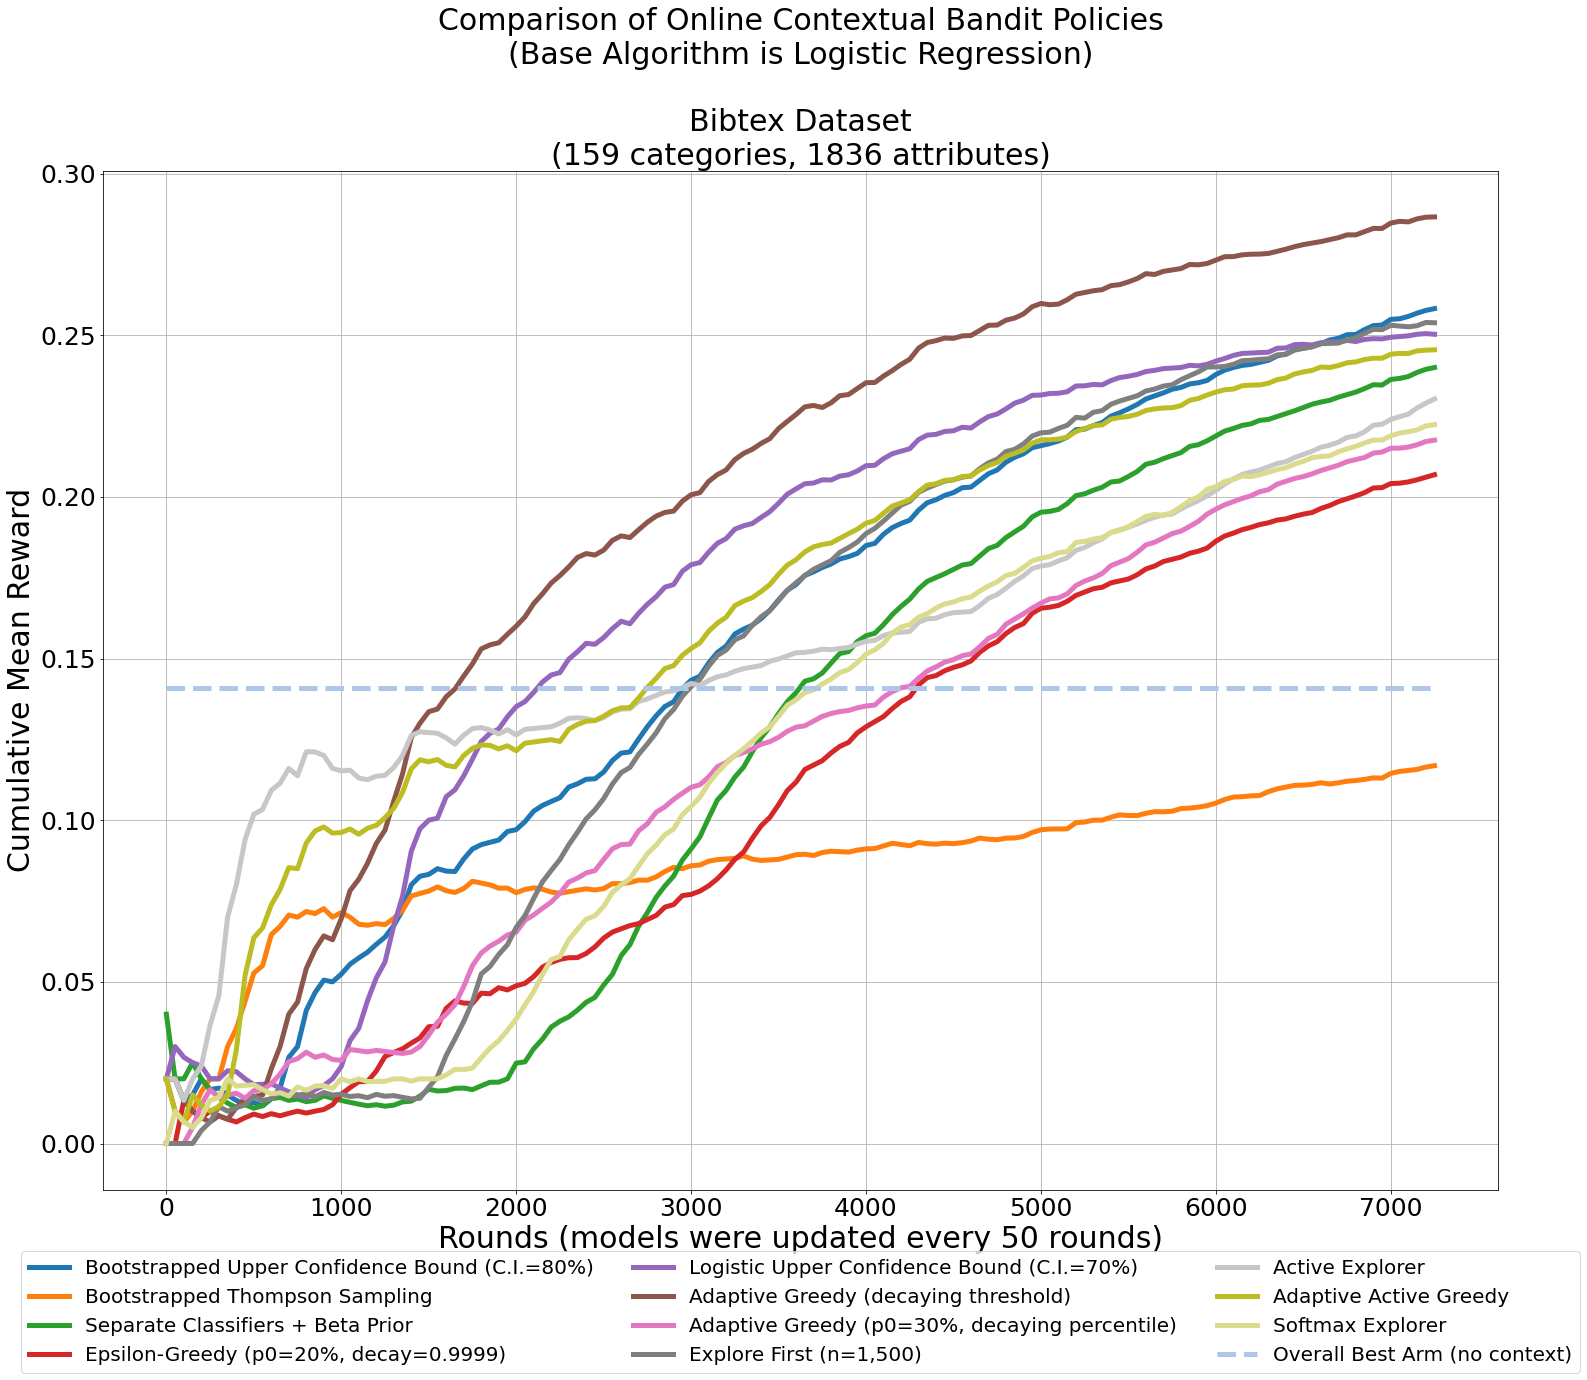

In [8]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 21))

ax = plt.subplot(111)
plt.plot(get_mean_reward(rewards_ucb), label="Bootstrapped Upper Confidence Bound (C.I.=80%)",linewidth=lwd,color=colors[0])
plt.plot(get_mean_reward(rewards_ts), label="Bootstrapped Thompson Sampling",linewidth=lwd,color=colors[2])
plt.plot(get_mean_reward(rewards_ovr), label="Separate Classifiers + Beta Prior",linewidth=lwd,color=colors[4])
plt.plot(get_mean_reward(rewards_egr), label="Epsilon-Greedy (p0=20%, decay=0.9999)",linewidth=lwd,color=colors[6])
plt.plot(get_mean_reward(rewards_lucb), label="Logistic Upper Confidence Bound (C.I.=70%)",linewidth=lwd,color=colors[8])
plt.plot(get_mean_reward(rewards_agr), label="Adaptive Greedy (decaying threshold)",linewidth=lwd,color=colors[10])
plt.plot(get_mean_reward(rewards_agr2), label="Adaptive Greedy (p0=30%, decaying percentile)",linewidth=lwd,color=colors[12])
plt.plot(get_mean_reward(rewards_efr), label="Explore First (n=1,500)",linewidth=lwd,color=colors[14])
plt.plot(get_mean_reward(rewards_ac), label="Active Explorer", linewidth=lwd,color=colors[15])
plt.plot(get_mean_reward(rewards_aac), label="Adaptive Active Greedy", linewidth=lwd,color=colors[16])
plt.plot(get_mean_reward(rewards_sft), label="Softmax Explorer", linewidth=lwd,color=colors[17])
#plt.plot(get_mean_reward(lst_rewards[-1]), label="Neural Bandit", linewidth=lwd,color=colors[19])
plt.plot(np.repeat(y.mean(axis=0).max(),len(rewards_sft)), label="Overall Best Arm (no context)",linewidth=lwd,color=colors[1],ls='dashed')


# import warnings
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])

plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cumulative Mean Reward', size=30)
plt.title(f'Comparison of Online Contextual Bandit Policies\n(Base Algorithm is Logistic Regression)\n\n{dataset_name} Dataset\n(159 categories, 1836 attributes)',size=30)
plt.grid()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 21))

ax = plt.subplot(111)
# plt.plot(get_mean_reward(rewards_ucb), label="Bootstrapped Upper Confidence Bound (C.I.=80%)",linewidth=lwd,color=colors[0])
# plt.plot(get_mean_reward(rewards_ts), label="Bootstrapped Thompson Sampling",linewidth=lwd,color=colors[2])
# plt.plot(get_mean_reward(rewards_ovr), label="Separate Classifiers + Beta Prior",linewidth=lwd,color=colors[4])
# plt.plot(get_mean_reward(rewards_egr), label="Epsilon-Greedy (p0=20%, decay=0.9999)",linewidth=lwd,color=colors[6])
# plt.plot(get_mean_reward(rewards_lucb), label="Logistic Upper Confidence Bound (C.I.=70%)",linewidth=lwd,color=colors[8])
# plt.plot(get_mean_reward(rewards_agr), label="Adaptive Greedy (decaying threshold)",linewidth=lwd,color=colors[10])
# plt.plot(get_mean_reward(rewards_agr2), label="Adaptive Greedy (p0=30%, decaying percentile)",linewidth=lwd,color=colors[12])
# plt.plot(get_mean_reward(rewards_efr), label="Explore First (n=1,500)",linewidth=lwd,color=colors[14])
# plt.plot(get_mean_reward(rewards_ac), label="Active Explorer", linewidth=lwd,color=colors[15])
# plt.plot(get_mean_reward(rewards_aac), label="Adaptive Active Greedy", linewidth=lwd,color=colors[16])
# plt.plot(get_mean_reward(rewards_sft), label="Softmax Explorer", linewidth=lwd,color=colors[17])

for i in range(len(rewards_neural_bandits)):
  print(f"Neural Bandit {neural_bandit_current_search} = {neural_bandit_parameter_list[i]}")
  print(get_mean_reward(rewards_neural_bandits[i])[-1])
  plt.plot(get_mean_reward(rewards_neural_bandits[i]), 
           label=f"Neural Bandit {neural_bandit_current_search} = {neural_bandit_parameter_list[i]}", 
           linewidth=lwd,color=colors[i])
plt.plot(np.repeat(y.mean(axis=0).max(),len(rewards_sft)), label="Overall Best Arm (no context)",linewidth=lwd,color=colors[1],ls='dashed')


# import warnings
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])

plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cumulative Mean Reward', size=30)
plt.title('Comparison of Online Contextual Bandit Policies\n(Base Algorithm is Logistic Regression)\n\nBibtext Dataset\n(159 categories, 1836 attributes)',size=30)
plt.grid()
plt.show()

In [ ]:
# Policy evaluation

In [ ]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.datasets import load_svmlight_file

def parse_data(filename):
    with open(filename, "rb") as f:
        infoline = f.readline()
        infoline = re.sub(r"^b'", "", str(infoline))
        n_features = int(re.sub(r"^\d+\s(\d+)\s\d+.*$", r"\1", infoline))
        features, labels = load_svmlight_file(f, n_features=n_features, multilabel=True)
    mlb = MultiLabelBinarizer()
    labels = mlb.fit_transform(labels)
    features = np.array(features.todense())
    features = np.ascontiguousarray(features)
    return features, labels

features, y = parse_data("Bibtex_data.txt")
print(features.shape)
print(y.shape)

(7395, 1836)
(7395, 159)


In [ ]:
from sklearn.linear_model import LogisticRegression

# the 'explorer' polcy will be fit to this small sample of the rows
st_seed = 0
end_seed = 2000

# then it will choose actions for this larger sample, which will be the input for the new policy
st_exploration = 0
end_exploration = 3000

# the new policy will be evaluated with a separate test set
st_test = 3000
end_test = 7395

# separating the covariates data for each case
Xseed = features[st_seed:end_seed, :]
Xexplore_sample = features[st_exploration:end_exploration, :]
Xtest = features[st_test:end_test, :]
nchoices = y.shape[1]

# now constructing an exploration policy as explained above, with fully-labeled data
explorer = LogisticRegression(C=0.1, solver="lbfgs", max_iter=15000)
explorer.fit(Xseed, np.argmax(y[st_seed:end_seed], axis=1))

# letting the exploration policy choose actions for the new policy input
actions_explore_sample=explorer.predict(Xexplore_sample)
rewards_explore_sample=y[st_exploration:end_exploration, :]\
                        [np.arange(end_exploration - st_exploration), actions_explore_sample]

# extracting the probabilities it estimated
ix_internal_actions = {j:i for i,j in enumerate(explorer.classes_)}
ix_internal_actions = [ix_internal_actions[i] for i in actions_explore_sample]
ix_internal_actions = np.array(ix_internal_actions)
prob_actions_explore = explorer.predict_proba(Xexplore_sample)[np.arange(Xexplore_sample.shape[0]),
                                                               ix_internal_actions]

# generating a test set with random actions
actions_test = np.random.randint(nchoices, size=end_test - st_test)
rewards_test = y[st_test:end_test, :][np.arange(end_test - st_test), actions_test]

In [ ]:
# Rejection sampling estimate:
from contextualbandits.online import SeparateClassifiers
from contextualbandits.evaluation import evaluateRejectionSampling

new_policy = SeparateClassifiers(LogisticRegression(C=0.1, solver="lbfgs", max_iter=15000),
                                 y.shape[1], smoothing=(1,2), beta_prior=None, random_state=123)
new_policy.fit(Xexplore_sample, actions_explore_sample, rewards_explore_sample)
est_r, ncases = evaluateRejectionSampling(new_policy, X=Xtest, a=actions_test, r=rewards_test,
                                          online=False)
real_r = np.mean(y[st_test:end_test,:][np.arange(end_test - st_test), new_policy.predict(Xtest)])

print('Test set Rejection Sampling mean reward estimate (new policy)')
print('Estimated mean reward: ',est_r)
print('Sample size: ', ncases)
print('----------------')
print('Real mean reward: ', real_r)

Test set Rejection Sampling mean reward estimate (new policy)
Estimated mean reward:  0.06896551724137931
Sample size:  29
----------------
Real mean reward:  0.1447098976109215


In [ ]:
est_r, ncases = evaluateRejectionSampling(explorer, X=Xtest, a=actions_test, r=rewards_test, online=False)
real_r = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), explorer.predict(Xtest)])

print('Test set Rejection Sampling mean reward estimate (old policy)')
print('Estimated mean reward: ', est_r)
print('Sample size: ', ncases)
print('----------------')
print('Real mean reward: ', real_r)

Test set Rejection Sampling mean reward estimate (old policy)
Estimated mean reward:  0.42857142857142855
Sample size:  21
----------------
Real mean reward:  0.4814562002275313


In [ ]:
actions_test_biased = explorer.predict(Xtest)
rewards_test_biased = y[st_test:end_test, :][np.arange(end_test - st_test), actions_test_biased]
est_r, ncases = evaluateRejectionSampling(new_policy, X=Xtest, a=actions_test_biased,
                                          r=rewards_test_biased, online=False)
real_r = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])

print('Biased Test set Rejection Sampling mean reward estimate (new policy)')
print('Estimated mean reward: ', est_r)
print('Sample size: ', ncases)
print('----------------')
print('Real mean reward: ', real_r)
print("(Don't try rejection sampling on a biased test set)")

Biased Test set Rejection Sampling mean reward estimate (new policy)
Estimated mean reward:  1.0
Sample size:  551
----------------
Real mean reward:  0.1447098976109215
(Don't try rejection sampling on a biased test set)


In [ ]:
from contextualbandits.evaluation import evaluateDoublyRobust
# import statsmodels.api as sm

# getting estimated probabilities for the biased test sample chosen by the old policy
ix_internal_actions = {j:i for i,j in enumerate(explorer.classes_)}
ix_internal_actions = [ix_internal_actions[i] for i in actions_test_biased]
ix_internal_actions = np.array(ix_internal_actions)
prob_actions_test_biased = explorer.predict_proba(Xtest)[np.arange(Xtest.shape[0]), ix_internal_actions]


# actions that the new policy will choose
pred = new_policy.predict(Xtest)

# method 1: estimating rewards by fitting another model to the whole data (train + test)
model_fit_on_all_data = SeparateClassifiers(LogisticRegression(C=0.1, solver="lbfgs", max_iter=15000),
                                            y.shape[1], random_state=123)
model_fit_on_all_data.fit(np.r_[Xexplore_sample, Xtest],
                          np.r_[actions_explore_sample, actions_test_biased],
                          np.r_[rewards_explore_sample, rewards_test_biased])
est_r_dr_whole = evaluateDoublyRobust(pred,
                                      X=Xtest, a=actions_test_biased, r=rewards_test_biased,
                                      p=prob_actions_test_biased, reward_estimator=model_fit_on_all_data,
                                      random_state=123)

# method 2: estimating rewards by fitting another model to the test data only
est_r_dr_test_only = evaluateDoublyRobust(pred, X=Xtest, a=actions_test_biased,
                                          r=rewards_test_biased, p=prob_actions_test_biased,
                                          reward_estimator=LogisticRegression(C=0.1, solver="lbfgs", max_iter=15000),
                                          nchoices=y.shape[1], random_state=123)

print('Biased Test set mean reward estimates (new policy)')
print('DR estimate (reward estimator fit on train+test): ', est_r_dr_whole)
print('DR estimate (reward estimator fit on test only): ', est_r_dr_test_only)
print('----------------')
print('Real mean reward: ', real_r)

Biased Test set mean reward estimates (new policy)
DR estimate (reward estimator fit on train+test):  0.7806511111850939
DR estimate (reward estimator fit on test only):  0.7838130617873124
----------------
Real mean reward:  0.1447098976109215


In [ ]:
from contextualbandits.evaluation import evaluateDoublyRobust
# import statsmodels.api as sm

# getting estimated probabilities for the biased test sample chosen by the old policy
# ix_internal_actions = {j:i for i,j in enumerate(explorer.classes_)}
# ix_internal_actions = [ix_internal_actions[i] for i in actions_test_biased]
# ix_internal_actions = np.array(ix_internal_actions)
# prob_actions_test_biased = explorer.predict_proba(Xtest)[np.arange(Xtest.shape[0]), ix_internal_actions]

# temp
actions_test_biased = actions_test
prob_actions_test_biased = np.array([1/len(actions_test)] * len(actions_test))
rewards_test_biased = rewards_test 

# actions that the new policy will choose
# pred = new_policy.predict(Xtest)
# temp
pred = explorer.predict(Xtest)

# method 1: estimating rewards by fitting another model to the whole data (train + test)
model_fit_on_all_data = SeparateClassifiers(LogisticRegression(C=0.1, solver="lbfgs", max_iter=15000),
                                            y.shape[1], random_state=123)
model_fit_on_all_data.fit(np.r_[Xexplore_sample, Xtest],
                          np.r_[actions_explore_sample, actions_test_biased],
                          np.r_[rewards_explore_sample, rewards_test_biased])
est_r_dr_whole = evaluateDoublyRobust(pred,
                                      X=Xtest, a=actions_test_biased, r=rewards_test_biased,
                                      p=prob_actions_test_biased, reward_estimator=model_fit_on_all_data,
                                      random_state=123)

# method 2: estimating rewards by fitting another model to the test data only
est_r_dr_test_only = evaluateDoublyRobust(pred, X=Xtest, a=actions_test_biased,
                                          r=rewards_test_biased, p=prob_actions_test_biased,
                                          reward_estimator=LogisticRegression(C=0.1, solver="lbfgs", max_iter=15000),
                                          nchoices=y.shape[1], random_state=123)

print('Biased Test set mean reward estimates (new policy)')
print('DR estimate (reward estimator fit on train+test): ', est_r_dr_whole)
print('DR estimate (reward estimator fit on test only): ', est_r_dr_test_only)
print('----------------')
print('Real mean reward: ', real_r)

Biased Test set mean reward estimates (new policy)
DR estimate (reward estimator fit on train+test):  0.6295344115377745
DR estimate (reward estimator fit on test only):  0.17204916680517077
----------------
Real mean reward:  0.4814562002275313


In [ ]:
len(prob_actions_test_biased)

4395

In [ ]:
len(actions_test_biased)

4395

In [ ]:
actions_test = np.random.randint(nchoices, size=end_test - st_test)

(array([437., 492., 419., 450., 415., 412., 420., 420., 470., 460.]),
 array([  0. ,  15.8,  31.6,  47.4,  63.2,  79. ,  94.8, 110.6, 126.4,
        142.2, 158. ]),
 <a list of 10 Patch objects>)

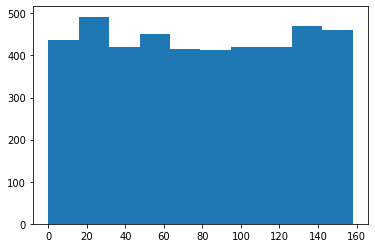

In [ ]:
import matplotlib.pyplot as plt
plt.hist(actions_test)

In [ ]:
prob_actions_test_biased

array([0.65872904, 0.88270726, 0.10261633, ..., 0.84928006, 0.92122532,
       0.14544288])

In [ ]:
ix_internal_actions

array([10, 14, 19, ..., 13, 14, 44])

In [ ]:
len(ix_internal_actions)

4395

In [ ]:
# Off-policy Learning in Contextual Bandits

In [ ]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.datasets import load_svmlight_file

def parse_data(filename):
    with open(filename, "rb") as f:
        infoline = f.readline()
        infoline = re.sub(r"^b'", "", str(infoline))
        n_features = int(re.sub(r"^\d+\s(\d+)\s\d+.*$", r"\1", infoline))
        features, labels = load_svmlight_file(f, n_features=n_features, multilabel=True)
    mlb = MultiLabelBinarizer()
    labels = mlb.fit_transform(labels)
    features = np.array(features.todense())
    features = np.ascontiguousarray(features)
    return features, labels

features, y = parse_data("Bibtex_data.txt")
print(features.shape)
print(y.shape)

(7395, 1836)
(7395, 159)


In [ ]:
from sklearn.linear_model import LogisticRegression

# the 'explorer' polcy will be fit with this small sample of the rows
st_seed = 0
end_seed = 3000

# then it will choose actions for this larger sample
st_exploration = 0
end_exploration = 5000

# the new policy will be evaluated with a separate test set
st_test = 5000
end_test = 7395

# separating the covariates data for each case
Xseed = features[st_seed:end_seed, :]
Xexplore_sample = features[st_exploration:end_exploration, :]
Xtest = features[st_test:end_test, :]
nchoices = y.shape[1]

# now constructing an exploration policy as explained above, with fully-labeled data
explorer = LogisticRegression(solver="lbfgs", max_iter=15000)
explorer.fit(Xseed, np.argmax(y[st_seed:end_seed], axis=1))

# letting the exploration policy choose actions for the new policy input
actions_explore_sample = explorer.predict(Xexplore_sample)
rewards_explore_sample = y[st_exploration:end_exploration, :]\
                        [np.arange(end_exploration - st_exploration), actions_explore_sample]

# extracting the probabilities it estimated
ix_internal_actions = {j:i for i,j in enumerate(explorer.classes_)}
ix_internal_actions = [ix_internal_actions[i] for i in actions_explore_sample]
ix_internal_actions = np.array(ix_internal_actions)
prob_actions_explore = explorer.predict_proba(Xexplore_sample)[np.arange(Xexplore_sample.shape[0]),
                                                               ix_internal_actions]

In [ ]:
from contextualbandits.online import SeparateClassifiers
from sklearn.linear_model import LogisticRegression

new_policy = SeparateClassifiers(base_algorithm=LogisticRegression(solver="lbfgs", max_iter=15000),
                                 nchoices=y.shape[1], beta_prior=None, smoothing=None)
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample)
mean_reward_naive = np.mean(y[st_test:end_test, :]\
                             [np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Separate Classifiers: ", mean_reward_naive)

Test set mean reward - Separate Classifiers:  0.01962421711899791


In [ ]:
from contextualbandits.online import SeparateClassifiers
from sklearn.linear_model import LogisticRegression

new_policy = SeparateClassifiers(base_algorithm=LogisticRegression(solver="lbfgs", max_iter=15000),
                                 nchoices=y.shape[1], beta_prior="auto")
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample)
mean_reward_beta = np.mean(y[st_test:end_test, :]\
                            [np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Separate Classifiers + Prior: ", mean_reward_beta)

Test set mean reward - Separate Classifiers + Prior:  0.08893528183716075


In [ ]:
from contextualbandits.online import SeparateClassifiers
from sklearn.linear_model import LogisticRegression

new_policy = SeparateClassifiers(base_algorithm=LogisticRegression(solver="lbfgs", max_iter=15000),
                                 nchoices=y.shape[1], beta_prior=None, smoothing = (1,2))
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample)
mean_reward_sm = np.mean(y[st_test:end_test, :]\
                            [np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Separate Classifiers + Smoothing: ", mean_reward_sm)

Test set mean reward - Separate Classifiers + Smoothing:  0.17995824634655533


In [ ]:
from contextualbandits.offpolicy import OffsetTree
from sklearn.linear_model import LogisticRegression

new_policy = OffsetTree(base_algorithm=LogisticRegression(solver="lbfgs", max_iter=15000), nchoices=y.shape[1])
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample, p=prob_actions_explore)
mean_reward_ot = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Offset Tree technique: ", mean_reward_ot)

Test set mean reward - Offset Tree technique:  0.3173277661795407


In [ ]:
from contextualbandits.offpolicy import DoublyRobustEstimator
from sklearn.linear_model import LogisticRegression, Ridge

new_policy = DoublyRobustEstimator(base_algorithm = Ridge(),
                                   reward_estimator = LogisticRegression(solver="lbfgs", max_iter=15000),
                                   nchoices = y.shape[1],
                                   method = 'rovr', beta_prior = None, smoothing = None)
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample, p=prob_actions_explore)
mean_reward_dr = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Doubly-Robust Estimator: ", mean_reward_dr)

Test set mean reward - Doubly-Robust Estimator:  0.42004175365344465


In [ ]:
new_policy = DoublyRobustEstimator(base_algorithm = Ridge(),
                                   reward_estimator = LogisticRegression(solver="lbfgs", max_iter=15000),
                                   nchoices = y.shape[1],
                                   method = 'rovr', beta_prior = "auto", smoothing = None)
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample, p=prob_actions_explore)
mean_reward_dr_prior = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Doubly-Robust Estimator + Prior: ", mean_reward_dr_prior)

Test set mean reward - Doubly-Robust Estimator + Prior:  0.42004175365344465


In [ ]:
new_policy = DoublyRobustEstimator(base_algorithm = Ridge(),
                                   reward_estimator = LogisticRegression(solver="lbfgs", max_iter=15000),
                                   nchoices = y.shape[1],
                                   method = 'rovr', beta_prior = None, smoothing = (1, 2))
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample, p=prob_actions_explore)
mean_reward_dr_sm = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Doubly-Robust Estimator + Smoothing: ", mean_reward_dr_sm)

Test set mean reward - Doubly-Robust Estimator + Smoothing:  0.41795407098121085


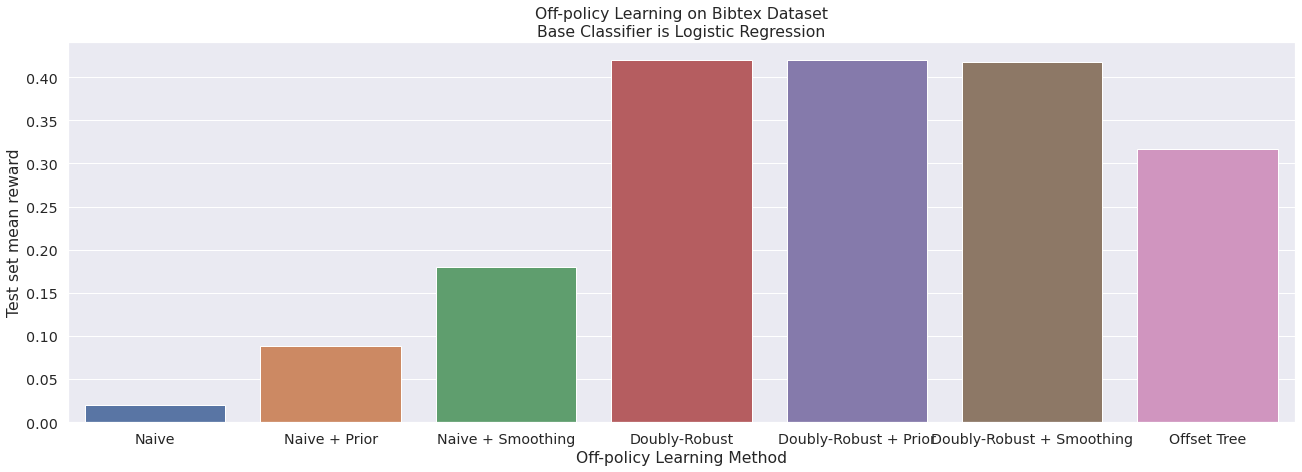

In [ ]:
import matplotlib.pyplot as plt, pandas as pd
import seaborn as sns
from pylab import rcParams
%matplotlib inline

results = pd.DataFrame({
    'Off-policy Learning Method' : ['Naive', 'Naive + Prior', 'Naive + Smoothing', 'Doubly-Robust',
                                    'Doubly-Robust + Prior', 'Doubly-Robust + Smoothing', 'Offset Tree'],
    'Test set mean reward' : [mean_reward_naive, mean_reward_beta, mean_reward_sm, mean_reward_dr,
                              mean_reward_dr_prior, mean_reward_dr_sm, mean_reward_ot]
})

sns.set(font_scale = 1.3)
rcParams['figure.figsize'] = 22, 7
sns.barplot(x = "Off-policy Learning Method", y="Test set mean reward", data=results)
plt.title('Off-policy Learning on Bibtex Dataset\nBase Classifier is Logistic Regression')
plt.show()